## Feature analysis by consecutive random forest

In [1]:
#importing libreries
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

seed = 42
np.random.seed(seed=seed)

### In this notebook, an analysis of the importance of features will be carried out by computing sequential random forests where at each iteration the feature with the least importance will be dropped. The analysis is inclusive of all columns in the dataset including those which are not present at submit time

#### Taking data and pre-processing features that are not numerical

In [2]:
def show_columns_type(data):
    for column in data.columns:
        print(column, "=", dtype(column))

In [24]:
data = pd.read_pickle("data/tmp.pkl")
data = data[(data.job_state != "CANCELLED") & (data.job_state != "NODE_FAIL")]
display(data.head())
print(len(data))

,pn_min_cpus,resize_time,ntasks_per_socket,tres_freq,comment,ntasks_per_socket_str,std_in,array_task_throttle,max_nodes,contiguous,...,cpus_allocated,billable_tres,last_sched_eval,eligible_time,power_flags,cores_per_socket,sockets_per_node,shared,cpus_per_task,req_nodes
0,4,1970-01-01 01:00:00+00:00,,,,UNLIMITED,/dev/null,,0,False,...,{'r245n04': 4},4.0,2020-05-22T01:07:00.000Z,2020-05-22 01:06:05+00:00,0,,,OK,4,['r245n04']
1,4,1970-01-01 01:00:00+00:00,,,,UNLIMITED,/dev/null,,0,False,...,{'r250n19': 4},4.0,2020-05-22T01:07:00.000Z,2020-05-22 01:06:10+00:00,0,,,OK,4,['r250n19']
3,4,1970-01-01 01:00:00+00:00,,,,UNLIMITED,/dev/null,,0,False,...,{'r209n15': 4},4.0,2020-05-22T20:39:06.000Z,2020-05-22 01:05:39+00:00,0,,,OK,4,['r209n15']
4,256,1970-01-01 01:00:00+00:00,2.0,,,2,/dev/null,,1,False,...,,,2020-05-22T18:56:39.000Z,2020-05-22 18:56:39+00:00,0,,,OK,32,
5,4,1970-01-01 01:00:00+00:00,,,,UNLIMITED,/dev/null,,0,False,...,{'r245n14': 4},4.0,2020-05-22T01:07:00.000Z,2020-05-22 01:06:06+00:00,0,,,OK,4,['r245n14']


1016530


In [25]:
data["state_reason"].unique()

array(['None', 'BadConstraints', 'NonZeroExitCode', 'TimeLimit',
       'JobLaunchFailure', 'OutOfMemory', 'Prolog', 'JobHeldUser'],
      dtype=object)

In [32]:
data["job_state"]

0          COMPLETED
1          COMPLETED
3          COMPLETED
4             FAILED
5          COMPLETED
             ...    
1074571    COMPLETED
1074572    COMPLETED
1074573       FAILED
1074574    COMPLETED
1074575    COMPLETED
Name: job_state, Length: 1016530, dtype: category
Categories (7, object): ['COMPLETED', 'CANCELLED', 'FAILED', 'TIMEOUT', 'OUT_OF_MEMORY', 'NODE_FAIL', 'PREEMPTED']

In [30]:
data["exit_code"]

0          0:0
1          0:0
3          0:0
4          0:1
5          0:0
          ... 
1074571    0:0
1074572    0:0
1074573    1:0
1074574    0:0
1074575    0:0
Name: exit_code, Length: 1016530, dtype: object

In [29]:
sum(data["job_state"].apply(lambda l: l!="COMPLETED"))

122118

In [19]:
data["job_state"]

0          COMPLETED
1          COMPLETED
2          CANCELLED
3          COMPLETED
4             FAILED
             ...    
1074571    COMPLETED
1074572    COMPLETED
1074573       FAILED
1074574    COMPLETED
1074575    COMPLETED
Name: job_state, Length: 1074576, dtype: category
Categories (7, object): ['COMPLETED', 'CANCELLED', 'FAILED', 'TIMEOUT', 'OUT_OF_MEMORY', 'NODE_FAIL', 'PREEMPTED']

In [18]:
data["exit_code"]

0           0:0
1           0:0
2          0:15
3           0:0
4           0:1
           ... 
1074571     0:0
1074572     0:0
1074573     1:0
1074574     0:0
1074575     0:0
Name: exit_code, Length: 1074576, dtype: object

In [17]:
data["exit_code"] = data["exit_code"].replace("", np.nan)
data["exit_code"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1074576 entries, 0 to 1074575
Series name: exit_code
Non-Null Count    Dtype 
--------------    ----- 
1074576 non-null  object
dtypes: object(1)
memory usage: 8.2+ MB


In [4]:
import re

fields = ["req_cpu", "req_mem", "req_node", "req_billing", "req_gpu"]
req_str = data.pop('tres_req_str')
data[fields] = req_str.str.split(',', n=5, expand=True)
for f in fields:
    data[f] = data[f].apply(lambda c: re.sub("[a-zA-Z=/]", "", c) if c is not None else 0)
    
data[fields] = data[fields].astype(float)

There are 'category', 'datetime' and 'object' features

In [5]:
for col in data.select_dtypes("datetime64[ns, UTC]").columns:
    data[col] = data[col].apply(lambda c: c.toordinal()).astype(int)

In [6]:
for col in data.select_dtypes(exclude=["int64", "float64"]).columns:
    data[col] = data[col].astype(object)

In [7]:
data =data.replace('', "-1")

All elements inside colunms are strings

Deleting rows classified with usless class for this task

In [8]:
values = ["OUT_OF_MEMORY", "COMPLETED", "FAILED", "TIMEOUT"]
data = data[data['job_state'].isin(values)]

Considering only two classes: completed job and others as failed.
Then encode job exit state as numerical for binary classification task

In [9]:
# labels = data["job_state"]
# data = data.drop(["job_state"], axis=1)

print("Old labels: ", np.unique(data["job_state"]))

data["job_state"][data["job_state"] == "OUT_OF_MEMORY"] = "FAILED"
data["job_state"][data["job_state"] == "TIMEOUT"] = "FAILED"

print("New labels: ", list(np.unique(data["job_state"])))

lab_enc = LabelEncoder()
lab_enc.fit(data["job_state"])
unique_labels = lab_enc.classes_
num_classes = len(unique_labels)

data["job_state"] = lab_enc.transform(data["job_state"]).astype(float)

Old labels:  ['COMPLETED' 'FAILED' 'OUT_OF_MEMORY' 'TIMEOUT']


/tmp/ipykernel_12281/693157671.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["job_state"][data["job_state"] == "TIMEOUT"] = "FAILED"


New labels:  ['COMPLETED', 'FAILED']


In [10]:
data.head()

,pn_min_cpus,resize_time,ntasks_per_socket,tres_freq,comment,ntasks_per_socket_str,std_in,array_task_throttle,max_nodes,contiguous,...,cores_per_socket,sockets_per_node,shared,cpus_per_task,req_nodes,req_cpu,req_mem,req_node,req_billing,req_gpu
0,4,1970-01-01 01:00:00+00:00,-1,-1,-1,UNLIMITED,/dev/null,-1,0,False,...,-1,-1,OK,4,['r245n04'],4.0,246000.0,1.0,4.0,0.0
1,4,1970-01-01 01:00:00+00:00,-1,-1,-1,UNLIMITED,/dev/null,-1,0,False,...,-1,-1,OK,4,['r250n19'],4.0,246000.0,1.0,4.0,0.0
3,4,1970-01-01 01:00:00+00:00,-1,-1,-1,UNLIMITED,/dev/null,-1,0,False,...,-1,-1,OK,4,['r209n15'],4.0,246000.0,1.0,4.0,0.0
4,256,1970-01-01 01:00:00+00:00,2.0,-1,-1,2,/dev/null,-1,1,False,...,-1,-1,OK,32,-1,256.0,230000.0,1.0,256.0,1.0
5,4,1970-01-01 01:00:00+00:00,-1,-1,-1,UNLIMITED,/dev/null,-1,0,False,...,-1,-1,OK,4,['r245n14'],4.0,246000.0,1.0,4.0,0.0


Converting all columns to numerical

In [13]:
from tqdm import tqdm

ord_enc = OrdinalEncoder(dtype=float)

for col in tqdm(list(data.select_dtypes(exclude=["int64", "float64"]).columns)):
    if all(data[col].str.isnumeric()):
        data[col] = data[col].astype(float)
    else:
        try:
            data[col] = data[col].apply(pd.to_numeric)
        except:
            val = data[col].values.reshape(-1, 1)
            data[col] = ord_enc.fit_transform(val)

100%|██████████| 95/95 [03:44<00:00,  2.36s/it]


Final Data

In [14]:
data.to_pickle("data/kaggle.pkl")
raise

RuntimeError: No active exception to reraise

#### Random Forest Analysis

#### Train, validation and test split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size=0.7, random_state=seed)

#### RF consecutive

In [ ]:
features_ranking = {}

In [ ]:
def random_forest():
    local_ranking = {}
    rf = RandomForestClassifier(random_state=seed)
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="binary")
    print("-------------------------------------------------------------------")
    print(f"F1 on test set: {f1}")
    print(f"Recall on test set: {recall}")
    print(f"Precision on test set: {precision}")
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    importances = pd.Series(rf.feature_importances_, index=x_train.columns)
    importances.sort_values(ascending=True, inplace=True)
    i = 0
    for key in importances.index:
      local_ranking.update({key : importances[i]})
      i = i + 1
    print("Local ranking: ", local_ranking)
    print("-------------------------------------------------------------------")
    return local_ranking

  0%|          | 0/1 [00:00<?, ?it/s]

Iteration number:  0
-------------------------------------------------------------------
F1 on test set: 0.8505086117211884
Recall on test set: 0.8440690604565791
Precision on test set: 0.8570471753057659


100%|██████████| 1/1 [01:36<00:00, 96.56s/it]

Local ranking:  {'group_id': 4.5731934844004935e-05, 'partition': 0.0015229155039559216, 'qos': 0.002253148625000886, 'cpus_per_task': 0.012308536834747514, 'req_node': 0.012762098605620815, 'req_billing': 0.02174440981528501, 'num_tasks': 0.023903451941540463, 'req_gpu': 0.02466039972331462, 'req_cpu': 0.026968892653150067, 'req_mem': 0.038615774498582355, 'time_limit': 0.06570907989572677, 'user_id': 0.08619239853528947, 'name': 0.11748273940689283, 'submit_time': 0.12479366171049187, 'priority': 0.19961353518619623, 'command': 0.24142322512936115}
-------------------------------------------------------------------


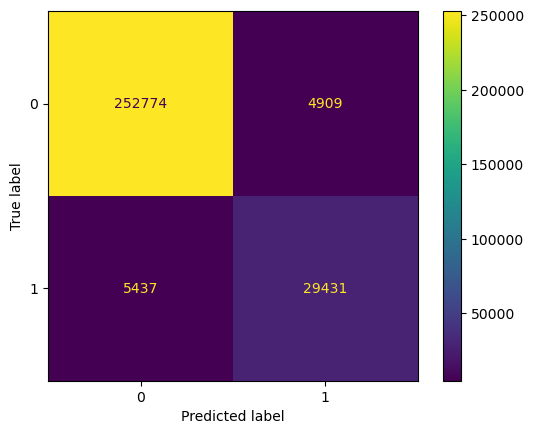

In [ ]:
for i in tqdm(range(0,1)):
  print("Iteration number: ", i)
  local_ranking = random_forest()
  column_to_drop = list(local_ranking.keys())[0]
  features_ranking.update({(99-i) : column_to_drop})
  x_train.drop(column_to_drop, axis='columns', inplace=True)
  x_test.drop(column_to_drop, axis='columns', inplace=True)